In [ ]:
import numpy as np
import pandas as pd
from pandas.util.testing import assert_frame_equal

In [ ]:
#from pandas_profiling import ProfileReport
%matplotlib inline

In [ ]:
df = pd.read_csv("/NO2LSTMDATASET.csv")

In [ ]:
df.head()

,date,value
0,20180430,0.000108
1,20180501,0.000111
2,20180502,0.000117
3,20180503,0.000088
4,20180505,0.000079


In [ ]:
dfnew = df.reset_index()['value']

In [ ]:
dfnew.shape

(711,)

In [ ]:
dfnew

0      0.000108
1      0.000111
2      0.000117
3      0.000088
4      0.000079
         ...   
706    0.000081
707    0.000061
708    0.000060
709    0.000085
710    0.000180
Name: value, Length: 711, dtype: float64

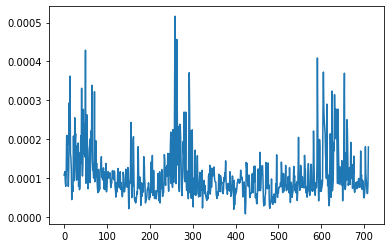

In [ ]:
import matplotlib.pyplot as plt
plt.plot(dfnew)

In [ ]:
import numpy as np


### Scaling Values of NO2 Conc. in between 0 and 1

In [ ]:
###Since LSTM is sensitive to range of data, we have redefined the range from 0 to 1,
### In the end, we will revert back to our original state
##using MINMAX SCALE

In [ ]:
print(dfnew)

0      0.000108
1      0.000111
2      0.000117
3      0.000088
4      0.000079
         ...   
706    0.000081
707    0.000061
708    0.000060
709    0.000085
710    0.000180
Name: value, Length: 711, dtype: float64


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
dfnew = scaler.fit_transform(np.array(dfnew).reshape(-1,1))

In [ ]:
print(dfnew)

[[0.196874  ]
 [0.2024749 ]
 [0.21434772]
 [0.15817017]
 [0.13970579]
 [0.19284843]
 [0.39066441]
 [0.39681351]
 [0.2201132 ]
 [0.26450346]
 [0.13898884]
 [0.23446579]
 [0.56197092]
 [0.35011773]
 [0.69754496]
 [0.30409779]
 [0.28313109]
 [0.2264065 ]
 [0.07214059]
 [0.11351859]
 [0.14021334]
 [0.11429508]
 [0.39388536]
 [0.18934339]
 [0.16790046]
 [0.48654437]
 [0.36790428]
 [0.40566411]
 [0.22233164]
 [0.1716655 ]
 [0.17131834]
 [0.34506321]
 [0.18929313]
 [0.35863143]
 [0.13868118]
 [0.3087798 ]
 [0.12244983]
 [0.13394687]
 [0.26221953]
 [0.39603986]
 [0.25677903]
 [0.63577302]
 [0.22160982]
 [0.19151058]
 [0.24699909]
 [0.5291435 ]
 [0.3316085 ]
 [0.30257802]
 [0.45283561]
 [0.28737834]
 [0.82835882]
 [0.15507139]
 [0.34640534]
 [0.50235989]
 [0.35127997]
 [0.32797068]
 [0.12737315]
 [0.23412921]
 [0.1953046 ]
 [0.30286885]
 [0.37859057]
 [0.15806599]
 [0.29262006]
 [0.42045692]
 [0.32083996]
 [0.6508343 ]
 [0.27304207]
 [0.22124783]
 [0.22369964]
 [0.18135713]
 [0.25110966]
 [0.61

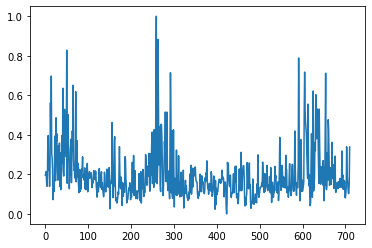

In [ ]:
plt.plot(dfnew) 

### Train-Test Split

In [ ]:
#80% of total for training dataset
training_size = int(len(dfnew)*0.8)
#20% of total for test dataset
test_size = len(dfnew)-training_size
train_data, test_data=dfnew[0:training_size,:],dfnew[training_size:len(dfnew),:1]

In [ ]:
training_size,test_size

(568, 143)

### Data Pre-Processing

In [ ]:
### Using 100 data points for x_train and next data point for y_train
### Moving 1 step forward each time, computing the same step 
import numpy
#array to dataset matrix
def create_dataset(dataset,  time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]       ## i from 0 to (time_step-1) will act as Xtrain, where time_step,th element will be ytrain
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(467, 100)
(467,)


(None, None)

In [ ]:
print(X_test.shape), print(ytest.shape)

(42, 100)
(42,)


(None, None)

In [ ]:
print(X_train)

[[0.196874   0.2024749  0.21434772 ... 0.17568182 0.25563397 0.11176587]
 [0.2024749  0.21434772 0.15817017 ... 0.25563397 0.11176587 0.13721245]
 [0.21434772 0.15817017 0.13970579 ... 0.11176587 0.13721245 0.18913041]
 ...
 [0.18422467 0.07254034 0.04018117 ... 0.29641947 0.2308599  0.22539326]
 [0.07254034 0.04018117 0.07973431 ... 0.2308599  0.22539326 0.1070395 ]
 [0.04018117 0.07973431 0.04449632 ... 0.22539326 0.1070395  0.13178456]]


In [ ]:
### Reshaping Input, by adding 1 more dimension
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
### Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)


Epoch 1/100
8/8 [==============================] - 3s 336ms/step - loss: 0.0204 - val_loss: 0.0065
Epoch 2/100
8/8 [==============================] - 1s 184ms/step - loss: 0.0103 - val_loss: 0.0043
Epoch 3/100
8/8 [==============================] - 1s 186ms/step - loss: 0.0097 - val_loss: 0.0051
Epoch 4/100
8/8 [==============================] - 1s 186ms/step - loss: 0.0096 - val_loss: 0.0038
Epoch 5/100
8/8 [==============================] - 2s 192ms/step - loss: 0.0095 - val_loss: 0.0038
Epoch 6/100
8/8 [==============================] - 2s 190ms/step - loss: 0.0093 - val_loss: 0.0041
Epoch 7/100
8/8 [==============================] - 1s 187ms/step - loss: 0.0092 - val_loss: 0.0037
Epoch 8/100
8/8 [==============================] - 2s 190ms/step - loss: 0.0094 - val_loss: 0.0039
Epoch 9/100
8/8 [==============================] - 2s 194ms/step - loss: 0.0092 - val_loss: 0.0038
Epoch 10/100
8/8 [==============================] - 2s 195ms/step - loss: 0.0090 - val_loss: 0.0044
Epoch 11/

In [ ]:
import tensorflow as tf


In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
### Scaler inverse to obtain original values of NO2 Concentration
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
### Root-Mean-Square-Error  
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.19624410847401125

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

0.18105863509694023

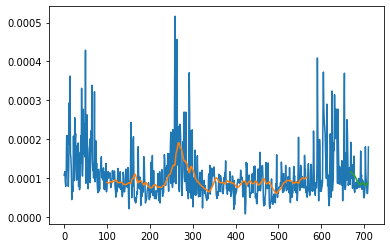

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(dfnew)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dfnew)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(dfnew)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dfnew))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)

143

In [ ]:
x_input=test_data[43:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:

temp_input

[0.23622807255088482,
 0.17905239615550028,
 0.555636480067024,
 0.2348411999919936,
 0.14257775546918397,
 0.19695740008275406,
 0.09383513839479002,
 0.041312841419731794,
 0.05978435707198268,
 0.2743829373870907,
 0.4051428460364588,
 0.3215344181014795,
 0.084285978761075,
 0.20992054496350776,
 0.6219513296455357,
 0.11660584117304426,
 0.15028895448415622,
 0.1786172654323702,
 0.3614199317348376,
 0.31978298250833154,
 0.6030863859534932,
 0.44280058832117675,
 0.38073317264136297,
 0.5316309384480039,
 0.4911670372242515,
 0.44898443729057147,
 0.3066415799254578,
 0.15424121179870726,
 0.5301722316621796,
 0.34822993801046564,
 0.2213404168491354,
 0.15075191850559733,
 0.23993004178119656,
 0.19042816271385973,
 0.22621513518900155,
 0.16725322906805312,
 0.14634288428228914,
 0.2693961467488235,
 0.23227974566774529,
 0.06636309372337558,
 0.22618028072698393,
 0.14590918208461975,
 0.4032248591045529,
 0.7118451773541828,
 0.1337901252810458,
 0.12295846127840485,
 0.14075

In [ ]:
### find next 30 days prediction

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30): ### predict for next 30 days
    
    if(len(temp_input)>100):### after running the else statement once, the size will be 100+1 = 101, we will move one step ahead to again predict yhat from these new 100 data points.
        #print(temp_input)
        x_input=np.array(temp_input[1:]) ##shifiting one position 
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)  ##same step as in else loop explained
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))### reshaping of new data is required
        yhat = model.predict(x_input, verbose=0)### We are passing the above obtained 100 days data to predict next 30 days 
        print(yhat[0]) 
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist()) ## aat dding to the yhinside the final output, also to the previous input, (upper 100 elements increased to 101)
        i=i+1
    

print(lst_output)

[0.15544523]
101
1 day input [0.1790524  0.55563648 0.2348412  0.14257776 0.1969574  0.09383514
 0.04131284 0.05978436 0.27438294 0.40514285 0.32153442 0.08428598
 0.20992054 0.62195133 0.11660584 0.15028895 0.17861727 0.36141993
 0.31978298 0.60308639 0.44280059 0.38073317 0.53163094 0.49116704
 0.44898444 0.30664158 0.15424121 0.53017223 0.34822994 0.22134042
 0.15075192 0.23993004 0.19042816 0.22621514 0.16725323 0.14634288
 0.26939615 0.23227975 0.06636309 0.22618028 0.14590918 0.40322486
 0.71184518 0.13379013 0.12295846 0.14075646 0.30996388 0.17051448
 0.4766048  0.42500673 0.27831604 0.14449    0.15696955 0.19474337
 0.23426482 0.14893131 0.21095008 0.3621311  0.19875943 0.1795074
 0.24976606 0.12920161 0.2112896  0.20029122 0.29267493 0.11973274
 0.10911076 0.12181606 0.13726337 0.15913546 0.15096992 0.12745528
 0.16371463 0.14867654 0.13472095 0.17902036 0.17851048 0.15284792
 0.13415335 0.17222767 0.31839065 0.18139076 0.19703302 0.12480196
 0.1710389  0.13339394 0.16536245 

In [ ]:
day_new=np.arange(1,101) ###100 days used to predict next 30 days, so 1 to 101
day_pred=np.arange(101,131) ### since prediction is on next 30 days, 101+30 = 131

In [ ]:
len(dfnew)



711

In [ ]:
import matplotlib.pyplot as plt


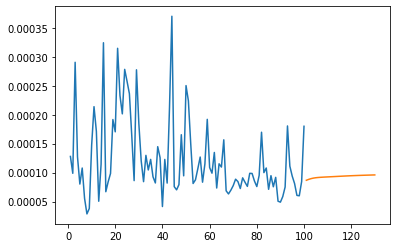

In [ ]:
plt.plot(day_new,scaler.inverse_transform(dfnew[611:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

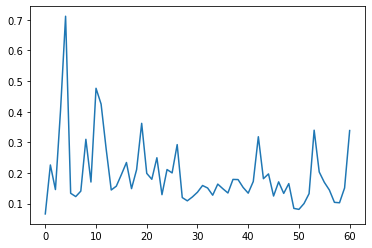

In [ ]:
plt.plot(dfnew[650:])

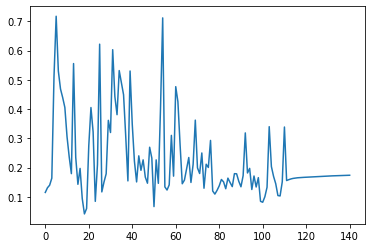

In [ ]:
df3 = dfnew.tolist()
df3.extend(lst_output)
plt.plot(df3[600:])
#plt.plot(lo1[700:],marker='.', color = 'green', markerfacecolor='green',)


In [ ]:
lo = pd.read_csv("/content/LSTMlockdown.csv")
lo.head()
lo1 = lo.reset_index()['value']
#dfnew.shape
lo1

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
747    0.000142
748    0.000043
749    0.000043
750    0.000047
751    0.000062
Name: value, Length: 752, dtype: float64

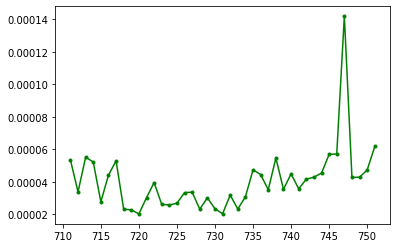

In [ ]:
plt.plot(lo1,marker='.', color = 'green', markerfacecolor='green',)